## Hugging Face datasets

In [9]:
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt


In [10]:
emotions_ds = load_dataset("emotion")

README.md:   0%|          | 0.00/9.05k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
emotions_ds

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [17]:
train_ds = emotions_ds["train"]
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [19]:
print(train_ds[0])
print(train_ds.column_names)
print(train_ds.features)

{'text': 'i didnt feel humiliated', 'label': 0}
['text', 'label']
{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}


In [20]:
emotions_ds.set_format("pandas")
train_df = emotions_ds["train"][:]
train_df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [31]:
train_ds.features['label'].names

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

In [32]:
train_df['label_name'] = train_df['label'].apply(lambda x: train_ds.features['label'].names[x])

In [33]:
train_df

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger
...,...,...,...
15995,i just had a very brief time in the beanbag an...,0,sadness
15996,i am now turning and i feel pathetic that i am...,0,sadness
15997,i feel strong and good overall,1,joy
15998,i feel like this was such a rude comment and i...,3,anger


## Check the Data

Text(0, 0.5, 'Emotion')

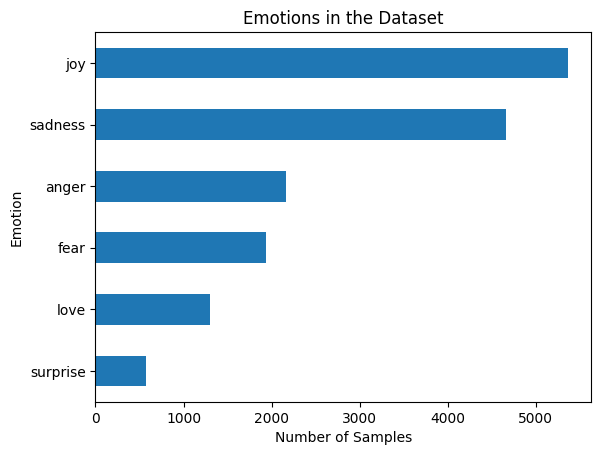

In [39]:
train_df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Emotions in the Dataset")
plt.xlabel("Number of Samples")
plt.ylabel("Emotion")

In [40]:
train_df["Words_per_tweet"] = train_df["text"].apply(lambda x: len(x.split()))

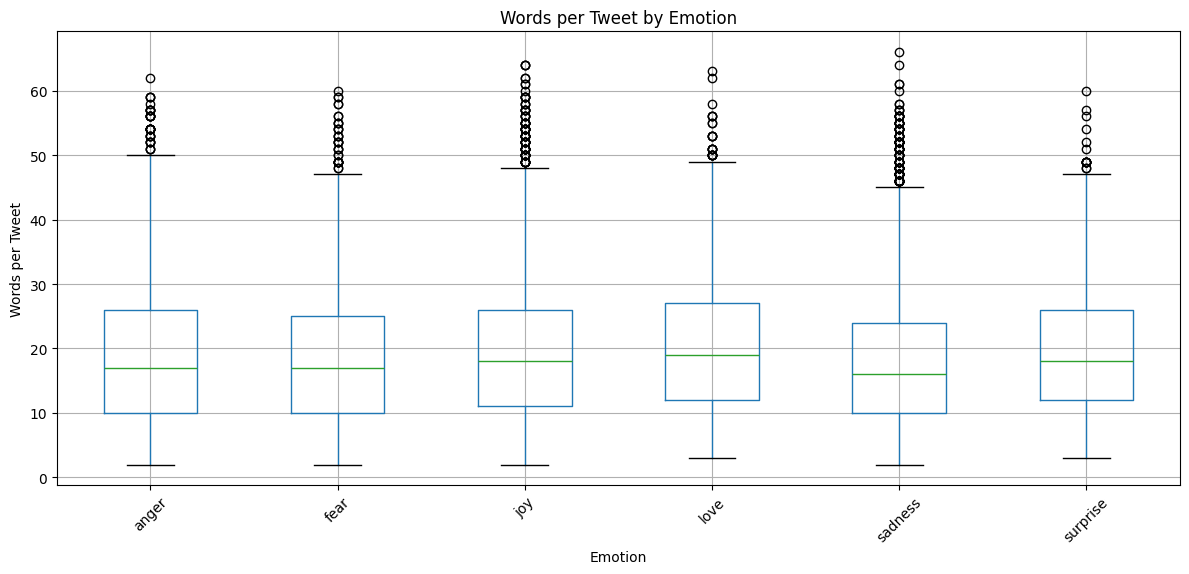

In [41]:
train_df.boxplot(column="Words_per_tweet", by="label_name", figsize=(12, 6))
plt.title("Words per Tweet by Emotion")
plt.suptitle("")
plt.xlabel("Emotion")
plt.ylabel("Words per Tweet")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [42]:
emotions_ds.reset_format()

## Tokenization

In [15]:
from transformers import AutoTokenizer
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [16]:
tokenized_string=tokenizer("hello, how are you?")

In [17]:
tokenized_string

{'input_ids': [101, 7592, 1010, 2129, 2024, 2017, 1029, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}

In [18]:
from transformers import DistilBertTokenizer
distilbert_tokenizer = DistilBertTokenizer.from_pretrained(model_ckpt)

In [9]:
tokenized_string = distilbert_tokenizer("hello, how are you?")
print(tokenized_string)

{'input_ids': [101, 7592, 1010, 2129, 2024, 2017, 1029, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}


In [10]:
distilbert_tokenizer.convert_ids_to_tokens(tokenized_string["input_ids"])


['[CLS]', 'hello', ',', 'how', 'are', 'you', '?', '[SEP]']

In [11]:
distilbert_tokenizer.vocab_size

30522

In [13]:
distilbert_tokenizer.model_max_length

512

In [14]:
distilbert_tokenizer.model_input_names

['input_ids', 'attention_mask']

## Tokenize the whole dataset

In [19]:
def tokenize(batch):
    return distilbert_tokenizer(batch["text"], padding=True, truncation=True)

In [20]:
print(tokenize(emotions_ds["train"][:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [21]:
emotions_ds_encoded = emotions_ds.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [22]:
print(emotions_ds_encoded["train"].column_names)

['text', 'label', 'input_ids', 'attention_mask']
